In [1]:
import os
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import median_abs_deviation as mad
from scipy.stats import spearmanr
import numpy as np

In [2]:
import warnings
warnings.simplefilter("ignore",FutureWarning)
warnings.simplefilter("ignore",UserWarning)
warnings.simplefilter("ignore",RuntimeWarning)

In [3]:
chan_adata_path = "/hpc/users/divagt01/watanabe/Divagar/transcriptomic_data/Chan/chan_sclc.h5ad"

In [4]:
chan_adata = sc.read(chan_adata_path)


In [5]:
chan_adata

AnnData object with n_obs × n_vars = 54313 × 22216
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'mito_frac', 'RBP_frac', 'batch', 'patient', 'tissue', 'treatment', 'procedure', 'SCLC_subtype', 'SCLC_subtype_plus_TP53_RB1_wt', 'pval_SCLC-A', 'pval_SCLC-N', 'pval_SCLC-P', 'NEUROD genes', 'MHCI_PRESENTATION', 'MHCII_PRESENTATION', 'SCLC_major_subtype_of_sample', 'clusters', 'treatment_categorized', 'recurrent_cluster', 'histo', 'clusters_fine'
    var: 'knnDREMI|PLCG2', 'PLCG2_modules', 'AXONOGENESIS', 'NEURON_DIFFERENTIATION', 'NEUROPEPTIDE_RECEPTOR', 'EMT'
    uns: 'diffmap_evals', 'neighbors', 'num_components', 'paga', 'umap', 'var_explained'
    obsm: 'X_diffmap', 'X_pca', 'X_umap'
    layers: 'imputed_normalized', 'log2(X+0.1)', 'normalized'
    obsp: 'connectivities', 'distances'

In [6]:
# QC
def qc(adata):
    sc.pp.filter_cells(adata, min_genes=100)
    sc.pp.filter_genes(adata, min_cells=3)
    adata.var["mt"]=adata.var_names.str.startswith("MT-")
    adata.var["ribo"]=adata.var_names.str.startswith(("RPS","RPL"))
    adata.var["hb"]=adata.var_names.str.contains(("^HB[^(P)]"))
    sc.pp.calculate_qc_metrics(adata,qc_vars=["mt","ribo","hb"], inplace=True, percent_top=[20], log1p=True)

    remove = ["total_counts_mt","log1p_total_counts_mt","total_counts_ribo","log1p_total_counts_ribo","total_counts_hb","log1p_total_counts_hb"]
    adata.obs=adata.obs[[x for x in adata.obs.columns if x not in remove]]
    
    return adata

In [7]:
qc(chan_adata)

AnnData object with n_obs × n_vars = 54303 × 22216
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'mito_frac', 'RBP_frac', 'batch', 'patient', 'tissue', 'treatment', 'procedure', 'SCLC_subtype', 'SCLC_subtype_plus_TP53_RB1_wt', 'pval_SCLC-A', 'pval_SCLC-N', 'pval_SCLC-P', 'NEUROD genes', 'MHCI_PRESENTATION', 'MHCII_PRESENTATION', 'SCLC_major_subtype_of_sample', 'clusters', 'treatment_categorized', 'recurrent_cluster', 'histo', 'clusters_fine', 'n_genes', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb'
    var: 'knnDREMI|PLCG2', 'PLCG2_modules', 'AXONOGENESIS', 'NEURON_DIFFERENTIATION', 'NEUROPEPTIDE_RECEPTOR', 'EMT', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'diffmap_evals', 'neighbors', 'num_components', 'paga', 'umap', 'var_explained'
    obsm: 'X_diffmap', 'X_pca', 'X_umap'
    layers: '

In [8]:
%matplotlib inline

Text(0, 0.5, '% Counts per cell mapping to rRNAs')

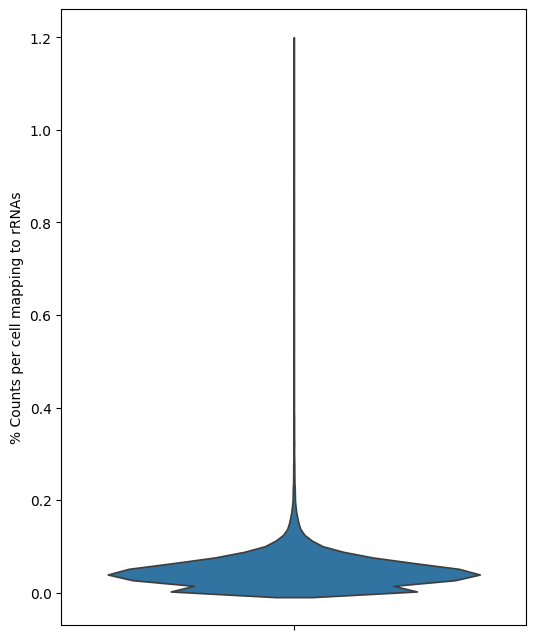

In [44]:
ribo_pct_data = chan_adata.obs['RBP_frac']*100
plt.figure(figsize=(6, 8))
sns.violinplot(y=ribo_pct_data, inner=None)
plt.ylabel('% Counts per cell mapping to rRNAs')

Text(0, 0.5, 'Log of number of reads per cell')

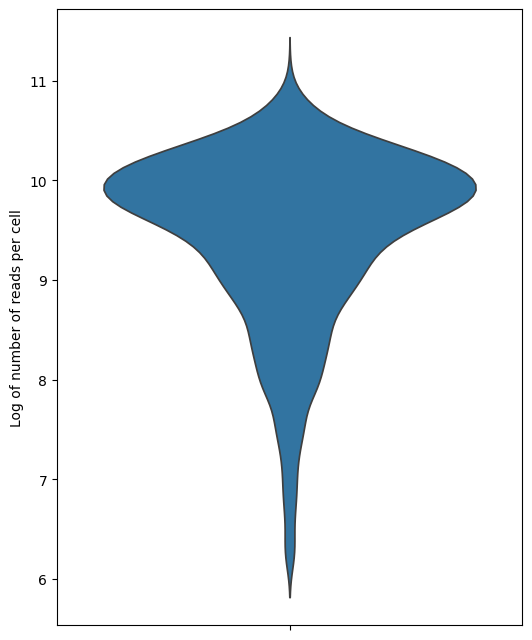

In [10]:
total_counts_data = ru1215_adata.obs['log1p_total_counts']
plt.figure(figsize=(6, 8))
sns.violinplot(y=total_counts_data, inner=None)
plt.ylabel('Log of number of reads per cell')

Text(0, 0.5, '% Counts per cell mapping to Mt genes')

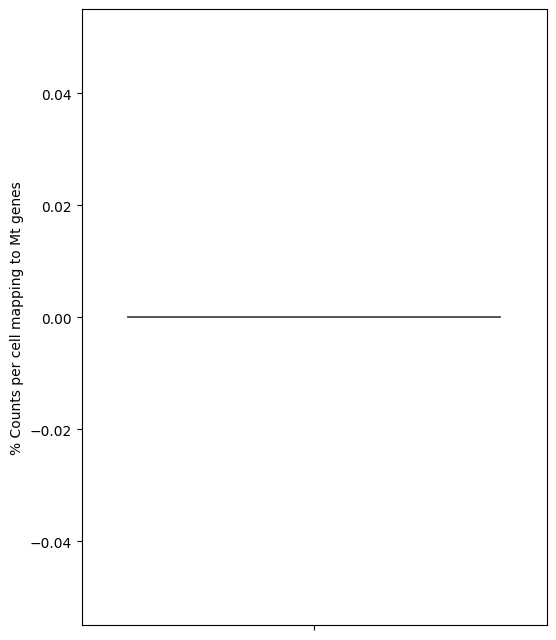

In [45]:
mito_pct_data = chan_adata.obs['mito_frac']*100
plt.figure(figsize=(6, 8))
sns.violinplot(y=mito_pct_data, inner=None)
plt.ylabel('% Counts per cell mapping to Mt genes')

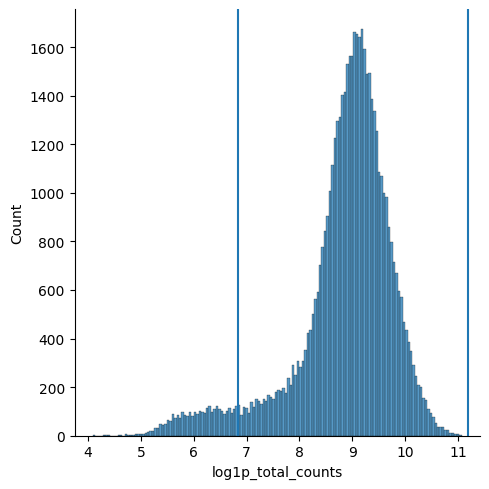

In [47]:
a = chan_adata.obs["log1p_total_counts"]
ax = sns.displot(a)
plt.axvline(np.median(a) - 5 * mad(a))
plt.axvline(np.median(a) + 5 * mad(a))
plt.show()

In [9]:
def mad_outlier(adata,metric,nmads,upper_only=False):
    M = adata.obs[metric]

    if not upper_only:
        return (M < np.median(M) - nmads * mad(M)) | (M > np.median(M) + nmads * mad(M))
    return (M > np.median(M) + nmads * mad(M))

In [10]:
def pp(adata):
    adata = adata[adata.obs.pct_counts_mt < 25].copy()  # Make a copy to avoid modifying original
    
    # Detect outliers using MAD (ensure mad_outlier is defined)
    bool_vector = mad_outlier(adata, 'log1p_total_counts', 5) |\
                  mad_outlier(adata, 'log1p_n_genes_by_counts', 5) |\
                  mad_outlier(adata, 'pct_counts_in_top_20_genes', 5) 
    
    adata = adata[~bool_vector]  # Apply boolean vector to filter out outliers

    # Record number of cells removed due to outliers
    adata.uns['cells_removed'] = sum(bool_vector)

    return adata

In [11]:
chan_adata = pp(chan_adata)

In [12]:
print(chan_adata.uns["cells_removed"])

4618


In [13]:
chan_adata

AnnData object with n_obs × n_vars = 49685 × 22216
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'mito_frac', 'RBP_frac', 'batch', 'patient', 'tissue', 'treatment', 'procedure', 'SCLC_subtype', 'SCLC_subtype_plus_TP53_RB1_wt', 'pval_SCLC-A', 'pval_SCLC-N', 'pval_SCLC-P', 'NEUROD genes', 'MHCI_PRESENTATION', 'MHCII_PRESENTATION', 'SCLC_major_subtype_of_sample', 'clusters', 'treatment_categorized', 'recurrent_cluster', 'histo', 'clusters_fine', 'n_genes', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb'
    var: 'knnDREMI|PLCG2', 'PLCG2_modules', 'AXONOGENESIS', 'NEURON_DIFFERENTIATION', 'NEUROPEPTIDE_RECEPTOR', 'EMT', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'diffmap_evals', 'neighbors', 'num_components', 'paga', 'umap', 'var_explained', 'cells_removed'
    obsm: 'X_diffmap', 'X_pca', 'X_um

In [57]:
patient_treatments = chan_adata.obs.groupby('patient')['treatment'].unique()
patient_treatments_df = patient_treatments.reset_index()
patient_treatments_df.iloc[0]['treatment']


['Platinum Doublet,Immunotherapy,TMZ,Other chem...]
Categories (6, object): ['Naive', 'Platinum Doublet', 'Platinum Doublet,Immunotherapy', 'Platinum Doublet,Immunotherapy,TMZ,Other chem..., 'Platinum Doublet,Immunotherapy,TMZ,Other chem..., 'Platinum Doublet,PARP inhibitor,TMZ']

In [62]:
naive_patients = chan_adata.obs[chan_adata.obs['treatment'] == 'Platinum Doublet,Immunotherapy,TMZ,Other chemotherapy']
naive_patient_count = naive_patients['patient'].nunique()
naive_patient_count

1

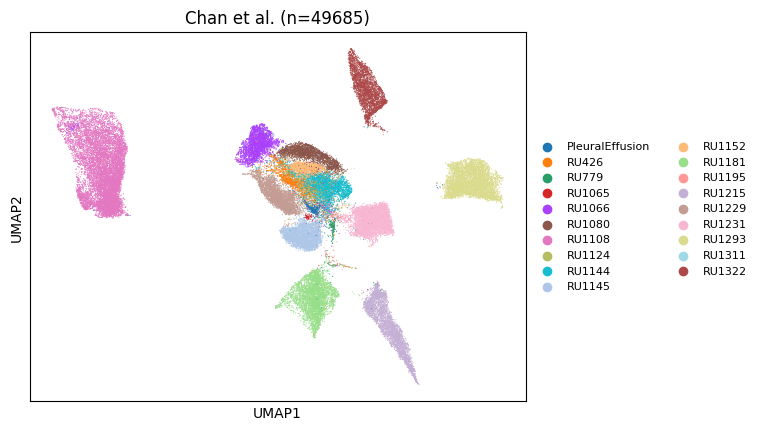

In [70]:
num_cells = chan_adata.n_obs
sc.pl.umap(chan_adata, color='patient',title=f"Chan et al. (n={num_cells})", add_outline=False,show=False,legend_fontsize=8)
plt.savefig("/hpc/users/divagt01/watanabe/Divagar/transcriptomic_data/Chan/plots/chan_umap_patients.png", dpi=600,bbox_inches='tight')

In [71]:
chan_adata.write("/hpc/users/divagt01/watanabe/Divagar/transcriptomic_data/Chan/chan_adata_qc_filtered.h5ad")

In [69]:
subtype_counts = chan_imputed_adata.obs['SCLC_subtype'].value_counts()
subtype_counts

SCLC_subtype
SCLC-A    28666
SCLC-N    18172
SCLC-P     2990
Name: count, dtype: int64

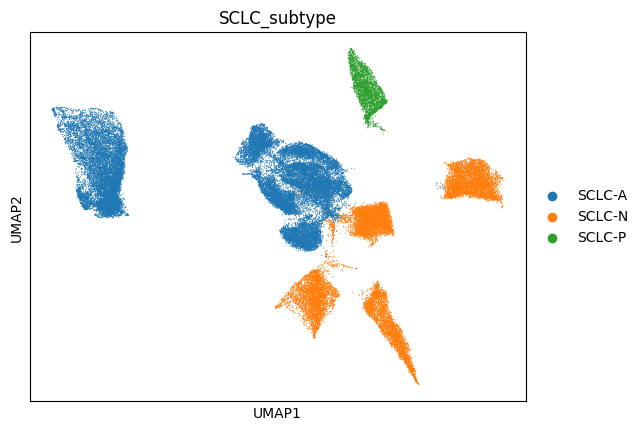

In [70]:
sc.pl.umap(chan_imputed_adata, color='SCLC_subtype')

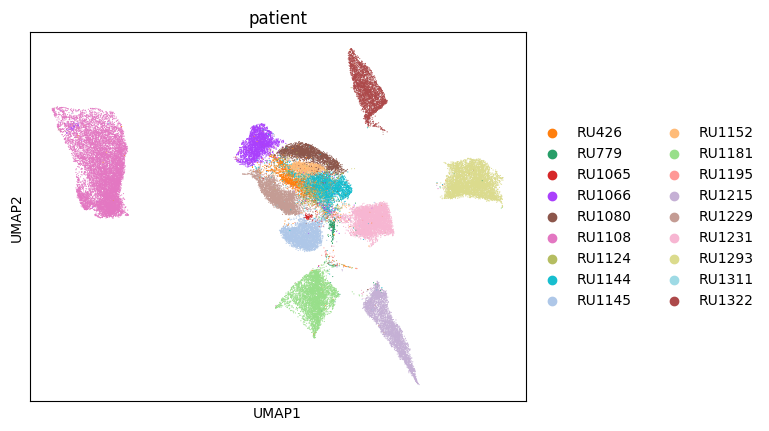

In [71]:
sc.pl.umap(chan_imputed_adata, color='patient')

In [73]:
patient_cell_counts = chan_imputed_adata.obs['patient'].value_counts()
patient_cell_counts

patient
RU1108    10509
RU1293     5260
RU1231     4837
RU1181     4126
RU1215     3768
RU1229     3226
RU1145     3079
RU1322     2967
RU1144     2870
RU1066     2652
RU1080     2549
RU1152     1419
RU426      1263
RU1124      760
RU779       183
RU1195      166
RU1065      101
RU1311       93
Name: count, dtype: int64

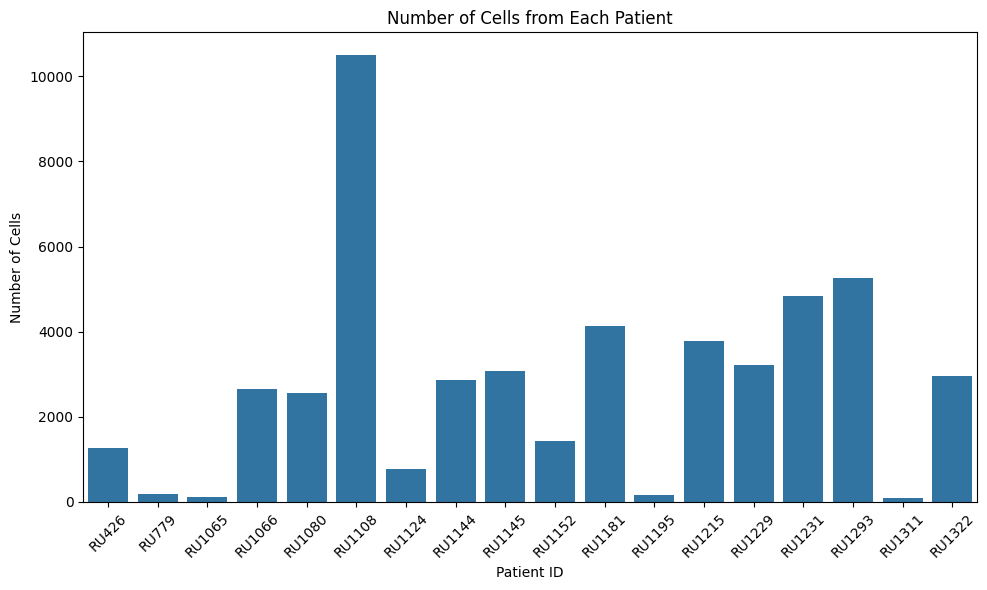

In [74]:
plt.figure(figsize=(10, 6))
sns.barplot(x=patient_cell_counts.index, y=patient_cell_counts.values)
plt.xlabel('Patient ID')
plt.ylabel('Number of Cells')
plt.title('Number of Cells from Each Patient')
plt.xticks(rotation=45)
plt.tight_layout()

In [75]:
chan_imputed_adata = chan_imputed_adata[chan_imputed_adata.obs['patient'] != 'RU779', :]
chan_imputed_adata = chan_imputed_adata[chan_imputed_adata.obs['patient'] != 'RU1065', :]
chan_imputed_adata = chan_imputed_adata[chan_imputed_adata.obs['patient'] != 'RU1195', :]
chan_imputed_adata = chan_imputed_adata[chan_imputed_adata.obs['patient'] != 'RU1311', :]

In [76]:
subtype_counts = chan_imputed_adata.obs['SCLC_subtype'].value_counts()
subtype_counts

SCLC_subtype
SCLC-A    28328
SCLC-N    17969
SCLC-P     2988
Name: count, dtype: int64

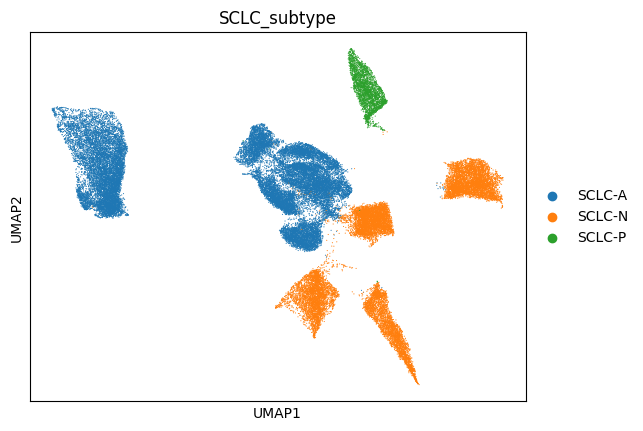

In [77]:
sc.pl.umap(chan_imputed_adata, color='SCLC_subtype')

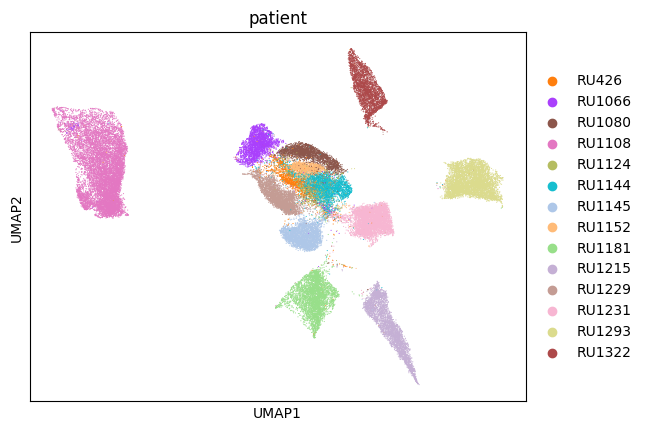

In [78]:
sc.pl.umap(chan_imputed_adata, color='patient')

In [81]:
chan_imputed_adata.var_names

Index(['A1BG', 'A1CF', 'A2M', 'A2ML1', 'A4GALT', 'AAAS', 'AACS', 'AADACL2',
       'AADACL4', 'AADAT',
       ...
       'ZWILCH', 'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11A', 'ZYG11B', 'ZYX',
       'ZZEF1', 'ZZZ3'],
      dtype='object', name='index', length=22216)

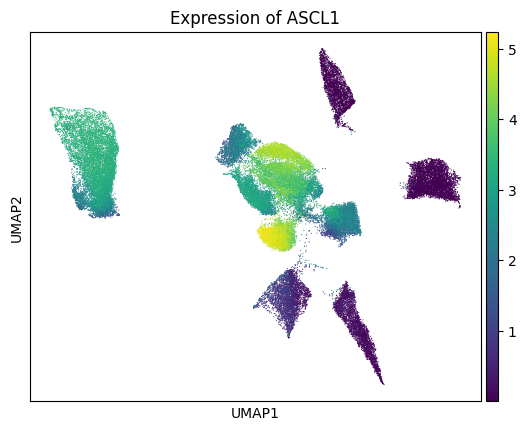

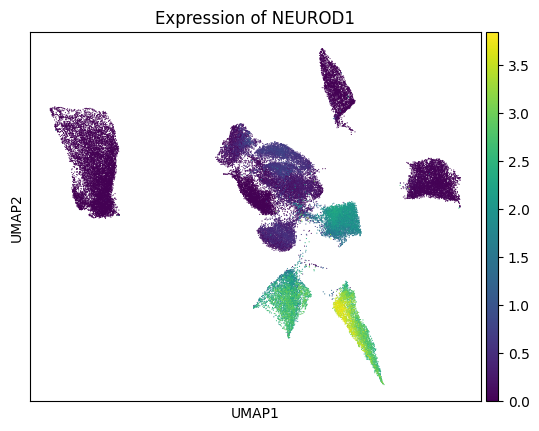

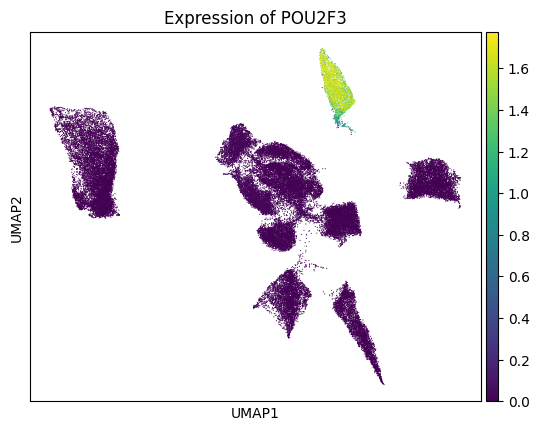

In [83]:
lineage_genes = ['ASCL1', 'NEUROD1','POU2F3']
for gene in lineage_genes:
    sc.pl.umap(chan_imputed_adata, color=gene, title=f'Expression of {gene}')

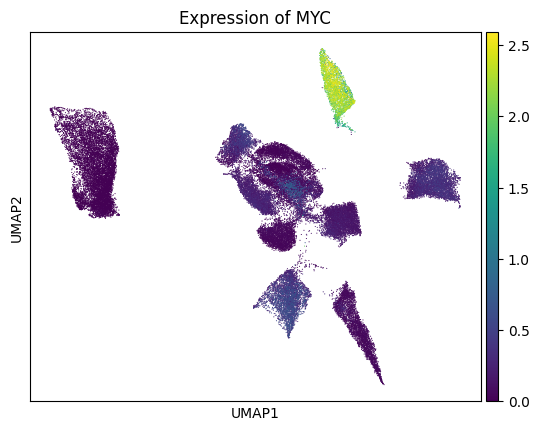

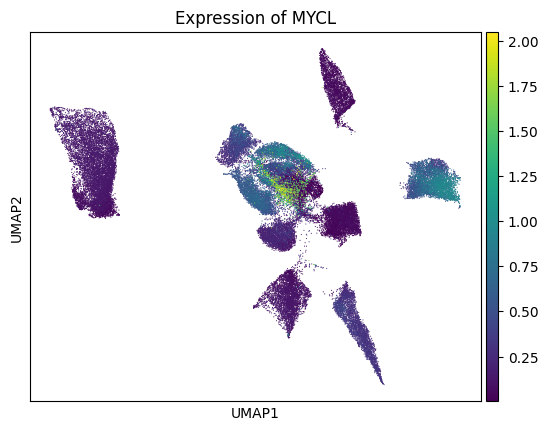

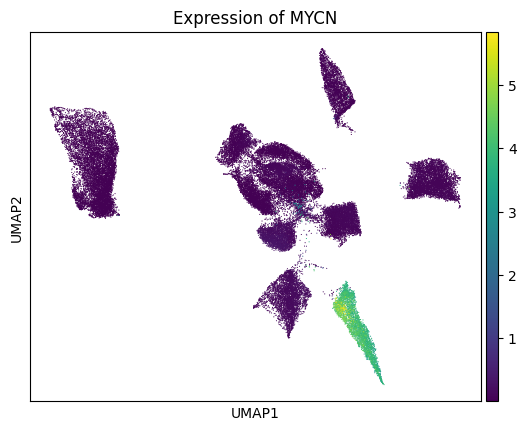

In [84]:
myc_genes = ['MYC', 'MYCL', 'MYCN']
for gene in myc_genes:
    sc.pl.umap(chan_imputed_adata, color=gene, title=f'Expression of {gene}')